# Particle spray algorithm by Chen et al. (2024) via `gala`

Author: Yingtian "Bill" Chen

We provide a notebook to generate streams using the Chen+24 ([arXiv:2408.01496](https://arxiv.org/abs/2408.01496)) model via `gala`. This implementation has been merged to the main branch of `gala` since version `v1.9`.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import astropy.units as u

import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.dynamics.nbody import DirectNBody
from gala.units import galactic, UnitSystem

### Set up galactic potential and initial conditions of the progenitor and the perturber (DM subhalo)

Here, we use the `MWPotential2014` potential by Bovy (2015).

In [2]:
pot = gp.BovyMWPotential2014(units=galactic)
H = gp.Hamiltonian(pot)

#Define progenitor information
prog_w0 = gd.PhaseSpacePosition(pos=[40, 0, 0] * u.kpc,
                                vel=[0, 100, 0] * u.km/u.s)
prog_mass = 1e5 * u.Msun


#Define DM subhalo information
perturber_w0 = gd.PhaseSpacePosition(pos=[41, 0, 0] * u.kpc, 
                                     vel=[-10, 100, 0] * u.km/u.s)
perturber_mass = 1e6 * u.Msun

#Define the combined initial conditions
w0_combined = gd.combine((prog_w0, perturber_w0))

### Generate streams!

Here is the case of backward integration, which is more commonly used for stream modeling. But you can do forward integration by simply fliping the sign of `dt`.

Specifics on run() : [https://gala.adrian.pw/en/latest/api/gala.dynamics.mockstream.MockStreamGenerator.html#gala.dynamics.mockstream.MockStreamGenerator.run ] 

Specifics on nbody : 
[https://gala.adrian.pw/en/latest/dynamics/nbody.html ]

In [3]:
#Potentials 
prog_pot = gp.PlummerPotential(m=prog_mass, b=4*u.pc, units=galactic) #progenitor
perturber_pot = gp.PlummerPotential(m=perturber_mass, b=4*u.pc, units=galactic) #DM
tot_pot = [prog_pot, perturber_pot]

In [4]:
#nbody = DirectNBody(w0_combined, tot_pot, external_potential=pot)
# orbits = nbody.integrate_orbit(dt=1e-2*u.Myr, t1=0, t2=1*u.Gyr)

perturber = gd.DirectNBody(perturber_w0, [perturber_pot], external_potential=pot)


In [5]:
df = ms.ChenStreamDF()
gen = ms.MockStreamGenerator(df, H, progenitor_potential=prog_pot) #there's no more arguments here

#nbody=nbody of DM because this is how many other objects can affect the stream

stream, prog = gen.run(prog_w0=prog_w0, prog_mass=prog_mass, nbody=perturber, release_every=1, n_particles=1, 
                                 output_every=True, output_filename='snapshots', check_filesize=True, overwrite=True, 
                                 progress=False, dt=-6*u.Myr, n_steps=500)#[source]



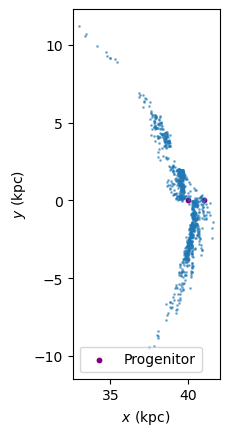

In [6]:
plt.scatter(prog.pos.x.value, prog.pos.y.value, color='purple', s=10, alpha=1, label = 'Progenitor')
plt.scatter(stream.pos.x.value, stream.pos.y.value, s=1, alpha=0.5) #, label='With perturber')

plt.xlabel(r'$x\ ({\rm kpc})$')
plt.ylabel(r'$y\ ({\rm kpc})$')
# plt.xlim(25, 50)
# plt.ylim(-15, 15)
plt.legend(loc='lower left')
plt.gca().set_aspect(1)
plt.show()

### Generate the movie!

In [7]:
import h5py    

f1 = h5py.File('snapshots','r+')    
f1

<HDF5 file "snapshots" (mode r+)>

In [8]:
import h5py

# Open the HDF5 file
with h5py.File('snapshots', 'r') as f:
    # Print all groups and datasets within the file
    def print_attrs(name, obj):
        print(f"{name}: {obj}")

    f.visititems(print_attrs)


nbody: <HDF5 group "/nbody" (3 members)>
nbody/pos: <HDF5 dataset "pos": shape (3, 501, 2), type "<f8">
nbody/time: <HDF5 dataset "time": shape (501,), type "<f8">
nbody/vel: <HDF5 dataset "vel": shape (3, 501, 2), type "<f8">
stream: <HDF5 group "/stream" (3 members)>
stream/pos: <HDF5 dataset "pos": shape (3, 501, 1002), type "<f8">
stream/time: <HDF5 dataset "time": shape (501,), type "<f8">
stream/vel: <HDF5 dataset "vel": shape (3, 501, 1002), type "<f8">


In [9]:
# Set the path to the ffmpeg binary
mpl.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'  # Adjust if ffmpeg is elsewhere


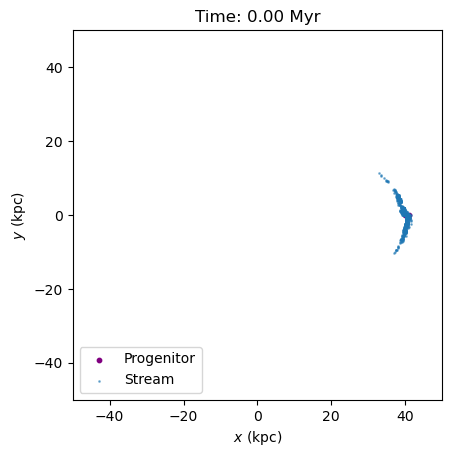

In [10]:
# Load the HDF5 file
with h5py.File('snapshots', 'r') as f:
    # Load the position and time data for the progenitor and stream
    prog_pos = f['nbody/pos'][:]  # Progenitor positions, shape (3, 501, 2)
    stream_pos = f['stream/pos'][:]  # Stream positions, shape (3, 501, 1002)
    time_data = f['nbody/time'][:]  # Time steps, shape (501,)

# Create a figure for the animation
fig, ax = plt.subplots()

# Initialize scatter plots for progenitor and stream
prog_scatter = ax.scatter([], [], color='purple', s=10, alpha=1, label='Progenitor')
stream_scatter = ax.scatter([], [], s=1, alpha=0.5, label='Stream')

# Set plot labels and aspect ratio
ax.set_xlabel(r'$x\ ({\rm kpc})$')
ax.set_ylabel(r'$y\ ({\rm kpc})$')
ax.set_aspect(1)
ax.legend(loc='lower left')

# Set the limits for the x and y axes
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)

# Update function for each frame in the animation
def update(frame):
    # Clear previous scatter points
    prog_scatter.set_offsets(prog_pos[:2, frame, :].T)
    stream_scatter.set_offsets(stream_pos[:2, frame, :].T)

    ax.set_title(f"Time: {time_data[frame]:.2f} Myr")

# Create the animation
ani = FuncAnimation(fig, update, frames=len(time_data), interval=50)

# Save the animation as a video file
ani.save('stream_simulation.mp4', writer='ffmpeg')

# Show the plot
plt.show()

In [11]:
# import matplotlib as mpl
# print(mpl.rcParams['animation.ffmpeg_path'])


In [12]:

# # Set the path to the ffmpeg binary
# mpl.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'  # Adjust if ffmpeg is elsewhere

# print(mpl.rcParams['animation.ffmpeg_path'])

# # /opt/homebrew/bin/ffmpeg

#
#
#
#
#
#
#
#

## If you have agama installed, the following compares the action space distribution

import agama # to calculate action
agama.setUnits(length=1, velocity=1, mass=1) # working units: 1 Msun, 1 kpc, 1 km/s

actFinder = agama.ActionFinder(agama.Potential('data/MWPotential2014.ini'))

def get_action(stream, prog, actFinder):
    pos_prog = prog.pos.xyz.to('kpc').value
    vel_prog = prog.vel.d_xyz.to('km/s').value
    posvel_prog = np.r_[pos_prog.squeeze(),vel_prog.squeeze()]
    action_prog = actFinder(posvel_prog)
    Jphi_prog = action_prog[2]
    Jr_prog = action_prog[0]
    
    pos = stream.pos.xyz.to('kpc').value
    vel = stream.vel.d_xyz.to('km/s').value
    posvel = np.column_stack((pos.T,vel.T))
    actions = actFinder(posvel)
    Jphi = actions[:,2]
    Jr = actions[:,0]
    
    # DLtot = Ltot - Ltot_prog
    DJphi = Jphi - Jphi_prog
    DJr = Jr - Jr_prog
    return DJphi, DJr
    
DJphi, DJr = get_action(stream_f15, prog_f15, actFinder)
plt.scatter(DJphi, DJr, s=1, alpha=0.5, label='Fardal+15')

DJphi, DJr = get_action(stream_c24, prog_c24, actFinder)
plt.scatter(DJphi, DJr, s=1, alpha=0.5, label='Chen+24 no prog.')

DJphi, DJr = get_action(stream_c24b, prog_c24b, actFinder)
plt.scatter(DJphi, DJr, s=1, alpha=0.5, label='Chen+24 with prog.')

plt.xlabel(r'$\Delta J_\phi\ ({\rm kpc\,km/s})$')
plt.ylabel(r'$\Delta J_r\ ({\rm kpc\,km/s})$')
plt.xlim(-120, 120)
plt.ylim(-100, 100)
plt.legend(loc='lower right')
plt.gca().set_aspect(1)
plt.show()